In [1]:
# Details of the object under study

Object = 'SN2017hpa'
Host = 'UGC 3122'
RA = '04:39:50.73'
DEC = '+07:03:55.22'
z = 0.016
EB_V_Gal = 0.1518              # Na ID around maximum (Turatto 2003)
EB_V_Gal_err = 0.0069            # Schlafly & Finkbeiner 2011
EB_V_Host = 0.08
EB_V_Host_err = 0.06
DM = 34.08
DM_err = 0.09                 # modz  http://leda.univ-lyon1.fr/ledacat.cgi?o=PGC%20021381
B_maximum =  2458066.29

In [2]:

# Import packages and module
#--------------------------------------------------------------------------------#
import os
import glob
import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator


#--------------------------------------------------------------------------------#
%config InlineBackend.figure_format ='retina'

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [4]:
SN_directory = '/Users/anirbandutta/Documents/SNEXP/Data/'

SN_data_UBVRI = SN_directory + '2017hpa_OUTPUT_FinalSNMag.txt'

In [5]:
FILTER_directory = '/Users/anirbandutta/Dropbox/astromatic/'            # Filter information 
FILTER_data = FILTER_directory+'FILTERS.dat'

In [6]:
# Read the filter file containing data on filters 

filter_df = pd.read_csv(FILTER_data, sep = '\s+')
filter_df = filter_df.replace('INDEF', np.nan).set_index(['FILTER', 'Marker', 'Color']).astype('float64')
filter_df = filter_df.reset_index().set_index('FILTER')
list_filters = filter_df.index.tolist()

In [7]:
# =============================================================================#
# Calculated in extinction_v1.py script using Fitzpatrick 1999 
# =============================================================================#
# This way gives us freedom to use different extinction law for Host

R_lambda_MW = {'uvw2': 8.80, 'uvm2': 9.31, 'uvw1': 6.63, 'uvu': 4.89, 'uvb': 4.12, 'uvv': 3.11,
               'U': 4.73, 'B': 4.09, 'V': 3.07, 'R': 2.44, 'I': 1.72, 'g': 3.72, 'r': 2.45}

R_lambda_HG = {'uvw2': 9.42, 'uvm2': 9.50, 'uvw1': 6.24, 'uvu': 3.78, 'uvb': 2.91, 'uvv': 1.90,
               'U': 3.57, 'B': 2.88, 'V': 1.87, 'R': 1.28, 'I': 0.87}

#R_lambda_HG = {'uvw2': 8.80, 'uvm2': 9.31, 'uvw1': 6.63, 'uvu': 4.89, 'uvb': 4.12, 'uvv': 3.11,
#               'U': 4.73, 'B': 4.09, 'V': 3.07, 'R': 2.44, 'I': 1.72, 'g': 3.72, 'r': 2.45}

# =============================================================================#

# =============================================================================#
# Calculate ZeroPoint
# =============================================================================#
Zeropoint = {'U': 4.18e-9, 'B': 6.32e-9, 'V': 3.63e-9, 'R': 2.18e-9, 'I': 1.13e-9,
            'uvw2': 5.36e-9, 'uvm2': 4.68e-9, 'uvw1': 4.15e-9, 'uvu': 3.63e-9, 'uvb': 6.48e-9,
            'uvv': 3.73e-9}


In [8]:
# Cell that contains all the important functions of the code


def group_similar_files(text_list, common_text, exceptions = ''):
    
    '''
    Remarks: A function to group similar kind of files in a directory.
    text_list: A text file used to store list of files
    common_text: A string (e.g. *.fits, *.list) used for grouping similar
    kinds of files
    exceptions: string of file name to exclude in grouping
    
    returns: list of grouped files
    '''
    
    list_files = glob.glob(common_text)
    if exceptions != '':
        list_exceptions = exceptions.split(',')
        for text in list_exceptions:
            list_files = filter(lambda x: not re.search(text, x), list_files)
        
    list_files.sort()
    if len(text_list) != 0:
        with open(text_list, 'w') as f:
            for file_name in list_files:
                f.write(file_name+'\n')
                
    return list_files   


def jd_to_date(jd, input_fmt='jd', output_fmt='isot'):
    
    '''
    Remarks: Convert jd to date
    jd: Input jd
    input_fmt: format of input ('jd')
    output_fmt: format of output ('iso', 'isot')
    returns: date
    '''
    
    from astropy.time import Time
    times = Time(jd, format=input_fmt)
    date_time = times.to_value(output_fmt)
    date = date_time.split('T')[0]
    
    return date

def apparent_mag_df(file_name, tempsub=False):
    
    
    '''
    Remarks: Creates an apparent magnitude dataframe
    file_name: file containing the SN magnitudes
    (JD, Filter, FMAG, FERR)
    tempsub: Whether the magnitudes are template subtracted
    returns: apparent magnitude dataframe
    '''
    
    appmag_df = pd.read_csv(file_name, sep = '\s+', engine = 'python')
    appmag_df = appmag_df.sort_values(by = ['FILTER', 'JD'], kind = 'mergesort')
    appmag_df = appmag_df[['JD','FILTER', 'FMAG', 'FERR']].reset_index(drop = True)
    
    return appmag_df

def columnwise_to_rowwise(name, data_df):
    
    '''
    Remarks: Change a dataframe in the form of (U,B,V,R,I) to 
    JD, FILTER, FMAG, FERR
    name: Name of the SN
    data_df: dataframe containing the UBVRI magnitudes.
    
    returns: output dataframe containing "Phase, Filter, Fmag, Ferr"
    Updates: Try this in pivot_table.
    '''
    
    ## List of column values to delete from a dataframe
    list_del = ['Date', 'Epoch', 'Seeing', 'EXPTIME', 'Y', 'YErr', 'J', 'JErr', 
           'H', 'HErr', 'K', 'KErr', 'g', 'gErr', 'r', 'rErr', 'i', 'iErr', 'Telescope']
    
    if 'Epoch' in data_df.columns.values:
        data_df['JD'] = data_df['JD'] + data_df['Epoch']
        
    #if 'Phase' not in data_df.columns:
    #    data_df['Phase'] = data_df['JD'] - SNdata_df.loc[name, 'B_maximum']
        
    
    data_df = data_df.set_index('JD')
    
    for column in list_del:
        if column in data_df.columns.values:
            data_df = data_df.drop(column, axis =1)
            
    data_arr = data_df.values
    size = data_arr.shape
    list_phase = np.repeat(data_df.index.values, (size[1]/2))
    list_filters = [x for x in data_df.columns.values if 'Err' not in x]
    data_arr = np.reshape(data_arr, [int(size[0]) * int(size[1]/2), 2])
    output_df = pd.DataFrame(data_arr, index = list_phase, columns = ['FMAG', 'FERR'])
    output_df.index.name = 'JD'
    output_df = output_df.reset_index(drop=False)
    output_df['FILTER'] = list_filters * size[0]
    output_df = output_df.replace('INDEF', np.nan).dropna(axis = 0, how = 'any')
    output_df = output_df[['JD', 'FILTER', 'FMAG', 'FERR']].reset_index(drop =True)
    output_df = output_df.sort_values(by = ['FILTER'], kind = 'mergesort')

    
    return output_df


def columnwise_to_rowwise1(name, data_df):
    
    '''
    Remarks: Change a dataframe in the form of (U,B,V,R,I) to 
    JD, FILTER, FMAG, FERR
    name: Name of the SN
    data_df: dataframe containing the UBVRI magnitudes.
    
    returns: output dataframe containing "Phase, Filter, Fmag, Ferr"
    Updates: Try this in pivot_table.
    '''
    
    ## List of column values to delete from a dataframe
    list_del = ['Date', 'Epoch', 'Seeing', 'Phase', 'EXPTIME', 'Y', 'YErr', 'J', 'JErr', 
           'H', 'HErr', 'K', 'KErr', 'g', 'gErr', 'r', 'rErr', 'i', 'iErr', 'Telescope']
    
    if 'Epoch' in data_df.columns.values:
        data_df['JD'] = data_df['JD'] + data_df['Epoch']
        
    #if 'Phase' not in data_df.columns:
    #    data_df['Phase'] = data_df['JD'] - SNdata_df.loc[name, 'B_maximum']
        
    
    data_df = data_df.set_index('JD')
    
    for column in list_del:
        if column in data_df.columns.values:
            data_df = data_df.drop(column, axis =1)
            
    print (data_df)
            
    data_arr = data_df.values
    size = data_arr.shape
    list_phase = np.repeat(data_df.index.values, (size[1]/2))
    list_filters = [x for x in data_df.columns.values if 'Err' not in x]
    data_arr = np.reshape(data_arr, [int(size[0]) * int(size[1]/2), 2])
    output_df = pd.DataFrame(data_arr, index = list_phase, columns = ['FMAG', 'FERR'])
    output_df.index.name = 'JD'
    output_df = output_df.reset_index(drop=False)
    output_df['FILTER'] = list_filters * size[0]
    output_df = output_df.replace('INDEF', np.nan).dropna(axis = 0, how = 'any')
    output_df = output_df[['JD', 'FILTER', 'FMAG', 'FERR']].reset_index(drop =True)
    output_df = output_df.sort_values(by = ['FILTER'], kind = 'mergesort')

    
    return output_df

def calculate_dm(dist, dist_err):
    
    '''
    Remarks:
    dist: Distance
    dist_err: error in the measured distance
    Returns the value of Distance Modulus and Distance Modulus Error.

    The distance modulus is a measure of the distance to an object in magnitude units. 
    An object with a distance modulus of 'zero' is exactly 10 parsecs away. 
    If an object has a negative distance modulus( D.M.), that means 
    it is closer than 10 parsecs and if it has a positive D.M.
    that means it is farther than 10 parsec.

    m-M = 5*log(D)-5
    Here m-M is called the Distance Modulus. 
    
    m : apparent magnitude of the object
    M : absolute magnitude of the object
    D : Distance to the object in parsec

    '''
    
    distmod = 5*np.log10(dist*1e6) - 5
    distmod_err = (5 * 0.434 * dist_err)/dist
    
    return [distmod, distmod_err]

# -------------------------------------------------------------------------------- #

def calculate_dist(dist_mod, dist_modd_err):
    
    d = (10**((dist_mod+5)/5))/10**6
    d_err = (2.303 * d * dist_modd_err)/5
    
    return d, d_err

# -------------------------------------------------------------------------------- #

def calculate_zp(band):
    
    zp = -2.5*np.log10(Zeropoint[band]) - 21.100
    zp = round(zp, 3)
    
    return zp

def cal_flux(mag, err, band, name, ext_err=False):
    
    mag = float(mag)
    err = float(err)
    zp = calculate_zp(band)
    
    if name != '':
        dist = pd.to_numeric(SNdata_df.loc[name, 'Distance'])
        dist_err = pd.to_numeric(SNdata_df.loc[name, 'Distance_err'])
        ebv = pd.to_numeric(SNdata_df.loc[name, 'EB_V'])
        ebv_err = pd.to_numeric(SNdata_df.loc[name, 'EB_V_err'])
        
    else:
        dist, dist_err = calculate_dist(DM, DM_err)
        ebv_MW = EB_V_Gal
        ebv_HG = EB_V_Host
        
        if ext_err:
            ebv_err_MW = EB_V_err_Gal
            ebv_err_HG = EB_V_err_Host
        else:
            ebv_err_MW = 0.0
            ebv_err_HG = 0.0
        
    ##---------- Distance Modulus ----------##
    distmod = 5*np.log10(dist*1e6) - 5
    distmod_err = (5 * 0.434 * dist_err)/dist
    ##--------------------------------------##
    
    ##---------- Absolute Magnitude ----------##
    absmag = mag - (R_lambda_MW[band] * ebv_MW) - (R_lambda_HG[band] * ebv_HG) - distmod
    absmag_err = (err**2 + (R_lambda_MW[band] * ebv_err_MW)**2 + 
                  (R_lambda_HG[band] * ebv_err_HG)**2 + distmod_err**2)**0.5
    ##--------------------------------------##
    
    ##---------- Flux ----------##
    flux = 10**(-0.4 * (mag - (R_lambda_MW[band] * ebv_MW) - (R_lambda_HG[band] * ebv_HG) 
                        + zp + 21.10))
    flux_err = 2.303 * flux * (0.4 * (err**2 + (R_lambda_MW[band] * ebv_err_MW)**2 + 
                  (R_lambda_HG[band] * ebv_err_HG)**2))
    ##--------------------------------------##
    
    ##---------- Luminosity ----------##
    val_lum = float(flux) * 4 * np.pi * (3.086e24)**2
    luminosity = (val_lum)*dist**2
    luminosity_err = (8*np.pi*flux) * (dist) * (dist_err) * (3.086e24)**2
    ##--------------------------------------## 
    
    return float(absmag), float(absmag_err), float(flux), float(flux_err), \
            float(luminosity), float(luminosity_err)


def sn_abs_df(sn_df, name):
    
    '''
    Info: 
    data: the SN-dataframe under study.
    B_max: maximum magnitude in B-band.
    
    Returns: the absolute magnitude dataframe along with separate dataframes for 
    total, B, V, R, I, U
    Remarks: Future version will include itertuples.
    
    '''
    
    #sn_df = pd.read_csv(data, sep = '\s+', engine = 'python')
    #sn_df['Date'] = sn_df['JD'].apply(lambda x: jd_2_gcal(x))
    sn_df['Phase'] = (sn_df['JD'] - B_maximum)/(1 + z)
    sn_df['FILTER'] = sn_df['FILTER'].apply(lambda x: x if 'UV' not in x else x.lower())

    for index, band in sn_df['FILTER'].items():
        if name != '':
            magflux = cal_flux(mag = sn_df.loc[index, 'FMAG'], 
                           err = sn_df.loc[index, 'FERR'], band = band, name = name)
        else:
            magflux = cal_flux(mag = sn_df.loc[index, 'FMAG'], 
                           err = sn_df.loc[index, 'FERR'], band = band, name = '')
        sn_df.loc[index, 'AbsMag'] = magflux[0]
        sn_df.loc[index, 'AbsErr'] = magflux[1]
        sn_df.loc[index, 'Flux'] = magflux[2]
        sn_df.loc[index, 'FluxErr'] = magflux[3]
        sn_df.loc[index, 'Lum'] = magflux[4]
        sn_df.loc[index, 'Lum_Err'] = magflux[5]
    
    return sn_df
                

In [9]:
# Make the file JD, FILTER, FMAG, FERR
# Optical LC
object_df_UBVRI = pd.read_csv(SN_data_UBVRI, sep='\s+', engine='python')
#sn_df_UBVRI = columnwise_to_rowwise(name='SN2011aa', data_df=object_df_UBVRI)
#sn_df_UBVRI = object_df_UBVRI[sn_df_UBVRI['FMAG'] != 99.990]


In [10]:
flux_df_UBVRI = sn_abs_df(object_df_UBVRI, name='')

In [11]:
sn_abs_df_B = flux_df_UBVRI[flux_df_UBVRI['FILTER'] == 'B']

In [12]:
sn_abs_df_I = flux_df_UBVRI[flux_df_UBVRI['FILTER'] == 'I']

In [13]:
sn_abs_df_R = flux_df_UBVRI[flux_df_UBVRI['FILTER'] == 'R']

In [14]:
sn_abs_df_U = flux_df_UBVRI[flux_df_UBVRI['FILTER'] == 'U']

In [15]:
sn_abs_df_V = flux_df_UBVRI[flux_df_UBVRI['FILTER'] == 'V']

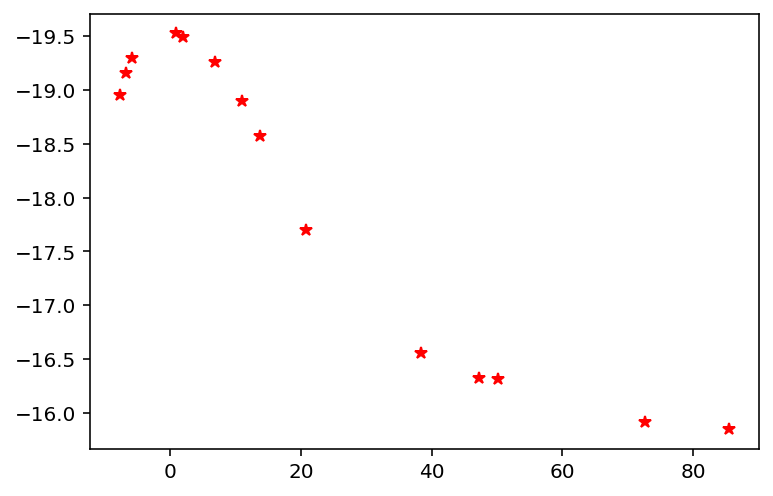

In [16]:
plt.plot(sn_abs_df_B['Phase'], sn_abs_df_B['AbsMag'], 'r*')
plt.gca().invert_yaxis()

In [17]:
filepath = '/Users/anirbandutta/Documents/SNEXP/Sedona_Models_Proj/'
model1_lc = filepath + 'lc_model_4.out'

In [18]:
columns = ['Time', 'Lbol', 'Mbol', 'U', 'B', 'V', 'Cousins_R', 'Cousins_I', 'UVW1', 'UVM2', 'UVW2']
sedona_lc1_df = pd.read_csv(model1_lc, names=columns, 
                             sep='\s+', engine='python', skiprows=2, comment='#')
sedona_lc1_df['Phase'] = sedona_lc1_df['Time'].apply(lambda x: x - 19.5)

sedona_lc1_df['U_Vega'] = sedona_lc1_df['U'] - 0.79
sedona_lc1_df['B_Vega'] = sedona_lc1_df['B'] + 0.09
sedona_lc1_df['V_Vega'] = sedona_lc1_df['V'] - 0.02
sedona_lc1_df['R_Vega'] = sedona_lc1_df['Cousins_R'] - 0.21
sedona_lc1_df['I_Vega'] = sedona_lc1_df['Cousins_I'] - 0.45

(-15.0, -20.1)

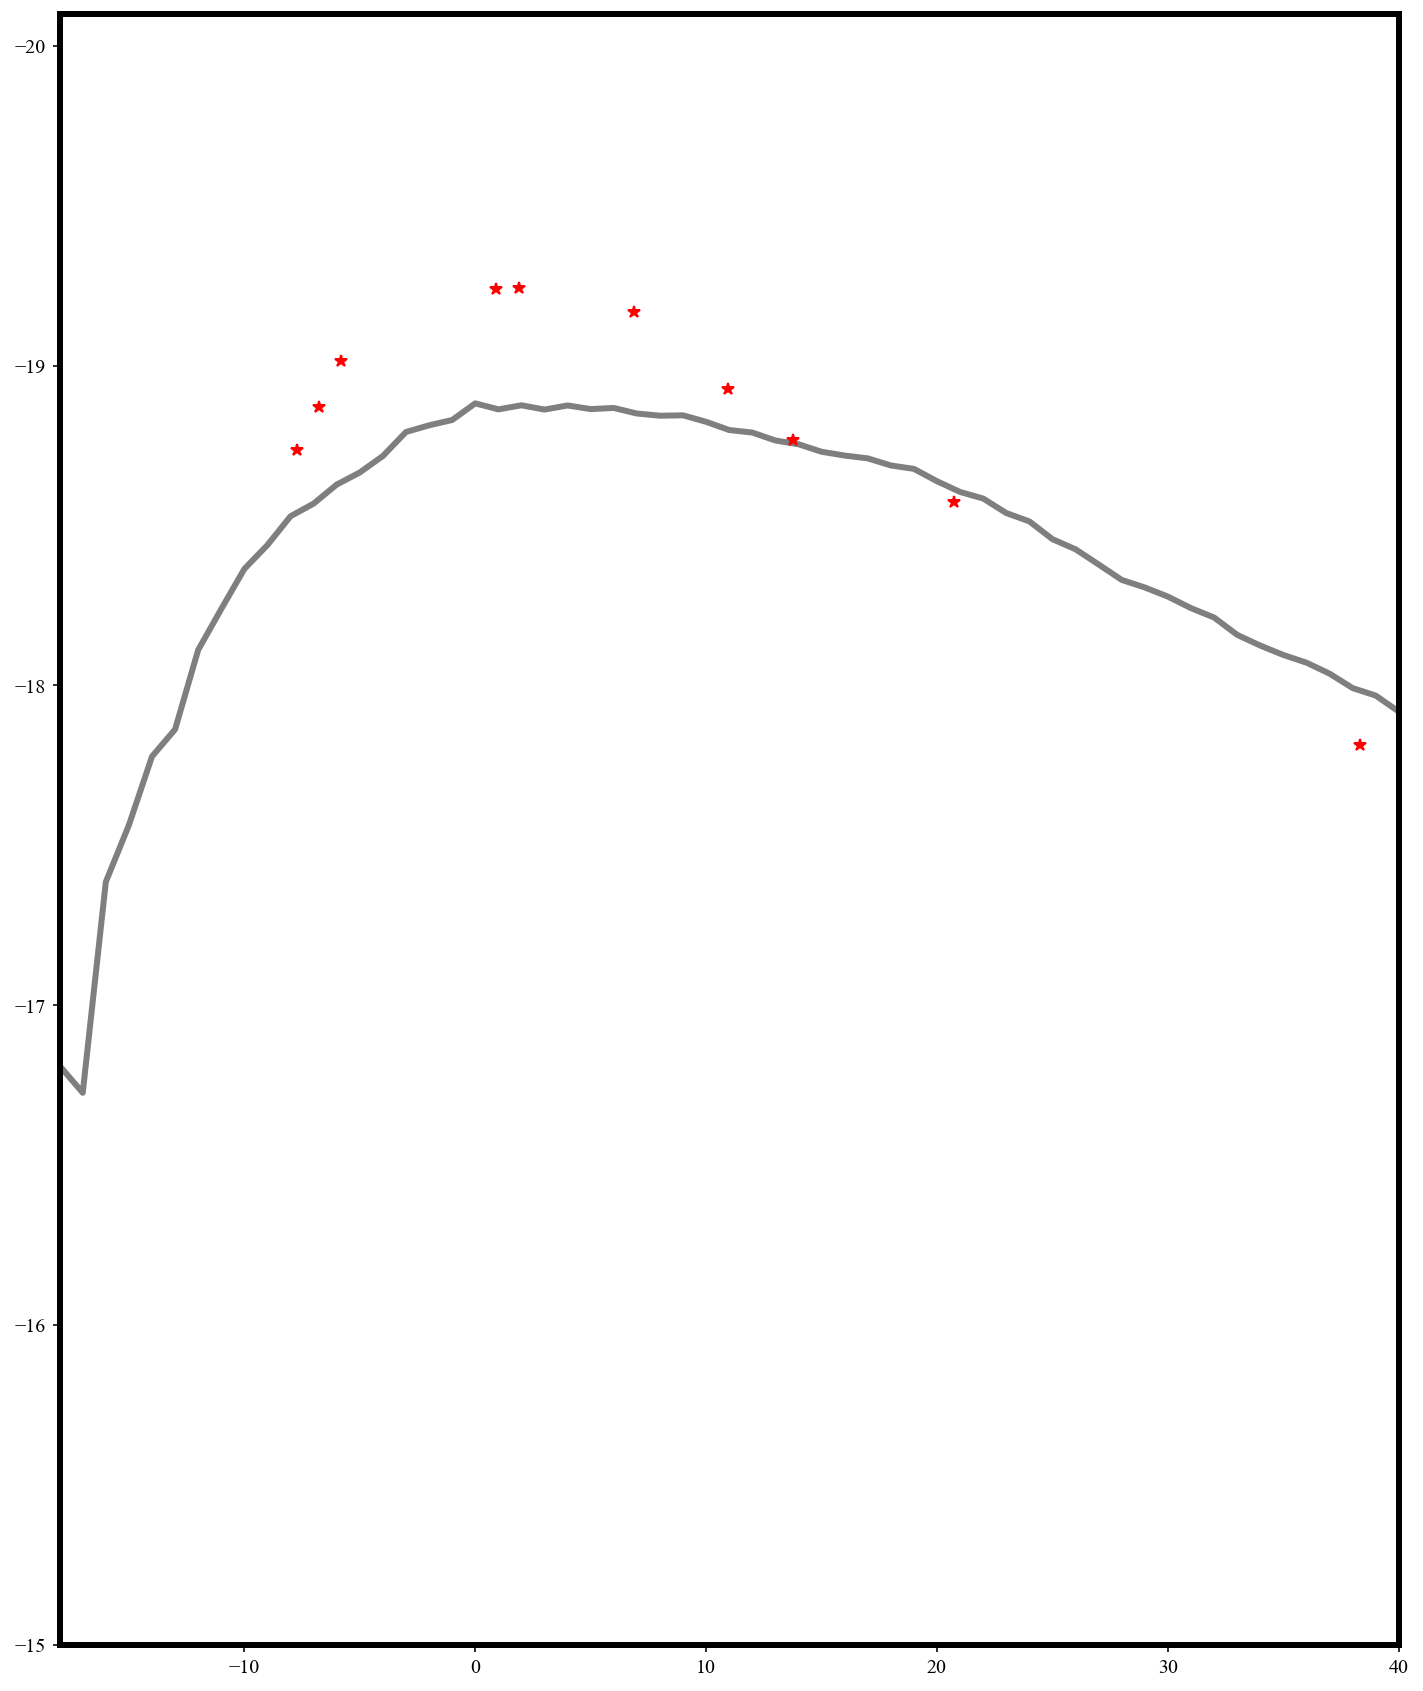

In [32]:
fig = plt.figure(figsize=(12, 15))
ax = fig.add_subplot(111)



#plot_params('A', ax, ml_x = 10, mil_x = 2, ml_y = 2, mil_y = 0.5, invert=True)
legend_properties = {'size':25, 'weight':'book'}
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.linewidth'] = 3

#-----------------------------------------------------------------------------------------------#
## UBVRI photometry dataframe
#ax.text(2, -22, '[A]', fontsize=25, fontweight='bold', color='black')    

# Model 1  (10^5 particles)

ax.plot(sedona_lc1_df['Phase'], sedona_lc1_df['R_Vega'], color='black', linewidth=3.0, ls='-', alpha=0.5, dash_capstyle='round')
ax.plot(sn_abs_df_R['Phase'], sn_abs_df_R['AbsMag'], 'r*')
ax.invert_yaxis()
ax.set_xlim(-18, 40)
ax.set_ylim(-15, -20.1)

In [21]:
sedona_lc1_df

,Time,Lbol,Mbol,U,B,V,Cousins_R,Cousins_I,UVW1,UVM2,UVW2,Phase,U_Vega,B_Vega,V_Vega,R_Vega,I_Vega
0,0.5,2.398012e+42,-17.252200,-15.46620,-15.64391,-14.509530,-15.382650,-14.173050,NaN,NaN,NaN,-19.0,-16.25620,-15.55391,-14.529530,-15.592650,-14.623050
1,1.5,3.202672e+43,-20.066360,-17.79236,-17.08339,-16.988100,-16.599920,-15.698400,NaN,NaN,NaN,-18.0,-18.58236,-16.99339,-17.008100,-16.809920,-16.148400
2,2.5,2.515659e+43,-19.804200,-18.16736,-17.82641,-17.117250,-16.515730,-16.245420,NaN,NaN,NaN,-17.0,-18.95736,-17.73641,-17.137250,-16.725730,-16.695420
3,3.5,2.679613e+43,-19.872760,-18.47049,-18.21491,-17.646780,-17.175210,-16.822970,NaN,NaN,NaN,-16.0,-19.26049,-18.12491,-17.666780,-17.385210,-17.272970
4,4.5,2.696279e+43,-19.879490,-18.57209,-18.40377,-17.650070,-17.353000,-17.036260,NaN,NaN,NaN,-15.0,-19.36209,-18.31377,-17.670070,-17.563000,-17.486260
5,5.5,2.562739e+43,-19.824340,-18.62024,-18.56885,-17.736080,-17.567430,-17.143640,NaN,NaN,NaN,-14.0,-19.41024,-18.47885,-17.756080,-17.777430,-17.593640
6,6.5,2.331502e+43,-19.721660,-18.60841,-18.67393,-17.739700,-17.652260,-17.387550,NaN,NaN,NaN,-13.0,-19.39841,-18.58393,-17.759700,-17.862260,-17.837550
7,7.5,2.107389e+43,-19.611940,-18.72953,-18.76236,-17.857420,-17.900650,-17.462020,NaN,NaN,NaN,-12.0,-19.51953,-18.67236,-17.877420,-18.110650,-17.912020
8,8.5,1.991997e+43,-19.550800,-18.83061,-18.78052,-18.026920,-18.028710,-17.735340,NaN,NaN,NaN,-11.0,-19.62061,-18.69052,-18.046920,-18.238710,-18.185340
9,9.5,1.908958e+43,-19.504570,-18.90725,-18.85003,-18.143630,-18.153940,-17.881510,NaN,NaN,NaN,-10.0,-19.69725,-18.76003,-18.163630,-18.363940,-18.331510
